# Аренда самокатов GoFast

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
без подписки
абонентская плата отсутствует;
стоимость одной минуты поездки —
8 рублей;
стоимость старта (начала поездки) —
50 рублей;
с подпиской Ultra
абонентская плата —
199 рублей в месяц;
стоимость одной минуты поездки —
6 рублей;
стоимость старта — бесплатно.

**Цель исследования** — проверим четыре гипотезы:
1. Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? .
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось.

**Ход исследования**

В основных данных есть информация о пользователях, их поездках и подписках.
Пользователи — users_go.csv Поездки — rides_go.csv Подписки — subscriptions_go.csv

Мы проверим данные на ошибки и оценим их влияние на исследование. Затем, проведем предобработку, исследовательский анализ и проверим гипотезы.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import binom
from math import sqrt

#### Шаг 1. Загрузка данных

1.1 Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы.

In [ ]:
try:
  # смотрим есть ли локально файл
  df_user = pd.read_csv('/datasets/users_go.csv', sep=',')
except:
  # если же его нет
  df_user = pd.read_csv('users_go.csv', sep=',')
try:
  # смотрим есть ли локально файл
  df_rides = pd.read_csv('/datasets/rides_go.csv', sep=',')
except:
  # если же его нет
  df_rides = pd.read_csv('rides_go.csv', sep=',')
try:
  # смотрим есть ли локально файл
  df_sub = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')
except:
  # если же его нет
  df_sub = pd.read_csv('subscriptions_go.csv', sep=',')

1.2 Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [ ]:
#pd.set_option('display.max_columns', None)
df_user.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [ ]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В таблице пользователей все хорошо. Типы данных соответствуют, пропусков нет.

In [ ]:
df_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [ ]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В таблице поездки не соотвтетствует тип данных поля date. Нужно  будет преобразовать в тип Date. Пропусков нет.

In [ ]:
df_sub.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [ ]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В данной таблице тоже все в порядке.

Изучив общую информацию заметила, что в датафреймы не очень большие, самый большой - о поздках, там 18068 записей. Все типы данных полей соответствуют, кроме датафрейма df_rides, поле date необходимо перевести в формат datetime. Пропусков в данных вообще не обнаружила. С именами полей тоже все в порядке.

#### Шаг 2. Предобработка данных

2.1 Приведите столбец date к типу даты pandas.

In [ ]:
# переведем date в формат date. Время не указано, поэтому формат без времени:
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Все получилось!

2.2 Создайте новый столбец с номером месяца на основе столбца date.

In [ ]:
# Добавляем столбец с номером месяца
df_rides['month'] = df_rides['date'].dt.month
# Проверим, что все получилось
df_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


2.3 Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [ ]:
# оценим суммарные пропуски в таблице users_go
df_user.isna().sum().sort_values(ascending=False)

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [ ]:
# оценим суммарные пропуски в таблице rides_go
df_rides.isna().sum().sort_values(ascending=False)

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [ ]:
# оценим суммарные пропуски в таблице subscriptions_go
df_sub.isna().sum().sort_values(ascending=False)

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков в данных нет

In [ ]:
# проверим за какой период у нас данные
print (max(df_rides['date']))
print (min(df_rides['date']))

2021-12-30 00:00:00
2021-01-01 00:00:00


Видим, что срез данных для анализа у нас с 1 января 2021 года по 30 декабря 2021 тоесть за 2021 год.

In [ ]:
#Округлим расстояния в df_rides['distance'] методом
df_rides['distance'] = round(df_rides['distance'])

In [ ]:
# Проверим столбец df_rides['duration'] на предмет наличия аномалий

df_rides.duration.describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [ ]:
# отсортируем и выведем самые большие расстояния
df_rides.duration.sort_values().head(30)
df_rides.query('duration < 1').count()

user_id     95
distance    95
duration    95
date        95
month       95
dtype: int64

Минимальное значение 0.5 мин, вряд ли это была поездка, скорей всего кто то пробовал взять самокат, но что то не получилось. Таких Значений достаточно много  95 с поездкой меньше минуты

In [ ]:
# Проверим таблицу df_user на дубликаты имен и названий городов
df_user['city'].unique()
df_user['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [ ]:
# Проверим таблицу df_user на дубликаты
df_user.duplicated().sum()

31

In [ ]:
# удалим явные дубликаты
df_user = df_user.drop_duplicates()

После предобработки данных можем сделать следующие выводы:

- данные для анализа предоставлены с 1 января 2021 года по 30 декабря 2021 (за 2021 год).
- в поле duration (время) минимальное значение 0.5 м, вряд ли это была поездка.
- явных дубликатов в полях name, city и в таблице с подписками поле subscription_type(тип подписки) не выявлено.
- выявлены явные дубликаты в таблице df_user и были удалены

#### Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:

3.1 частота встречаемости городов

In [ ]:
count_city = df_user['city'].value_counts()
count_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

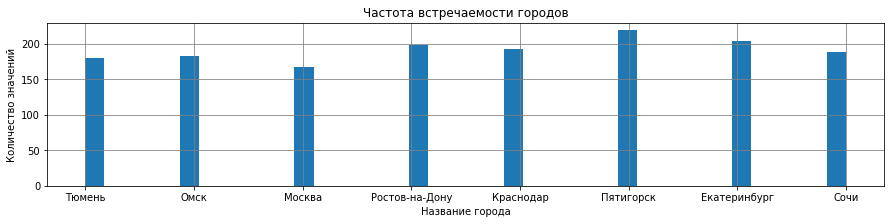

In [ ]:
plt.figure(figsize=(15, 3))
plt.hist(df_user['city'], bins = 40)
plt.title('Частота встречаемости городов')
plt.xlabel('Название города')
plt.ylabel('Количество значений')
plt.grid(color='grey', axis='both', alpha=5)
plt.show()

Чаще всего в данных втсречается город Пятигорск, на втором месте Екатеринбург. На последнем месте почему то Москва.

3.2 соотношение пользователей с подпиской и без подписки;

In [ ]:
# при помощи запроса сосчитаем количество пользователей с подпиской и без
user_ultra = df_user.query('subscription_type == "ultra"').copy()
user_free = df_user.query('subscription_type == "free"').copy()
ultra = round(user_ultra['name'].count() * 100 / df_user['name'].count())
free = round(user_free['name'].count() * 100 / df_user['name'].count())
print('Количество пользователей с подпиской: ', user_ultra['name'].count(), 'это', ultra, '%')
print('Количество пользователей без подписки: ', user_free['name'].count(), 'это', free, '%')

Количество пользователей с подпиской:  699 это 46 %
Количество пользователей без подписки:  835 это 54 %


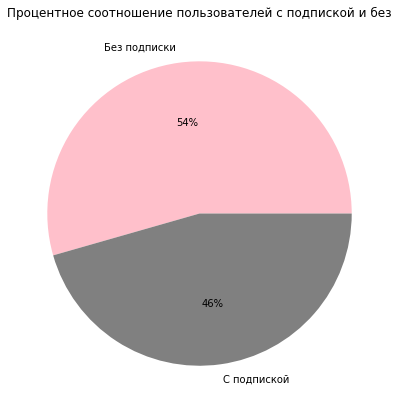

In [ ]:
# найдем их другим способом и построим диаграмму
colors = ("pink", "grey")
count_sub = df_user['subscription_type'].value_counts()
count_subfig = plt.figure(figsize =(10, 7))
subjects= ['Без подписки', 'С подпиской']
plt.pie(count_sub, colors = colors, autopct = '%1.0f%%', normalize = 'true', labels=subjects)
plt.title('Процентное соотношение пользователей с подпиской и без')
plt.show()

По графику видно, что количество пользователей без подписки всетаки большо, хотя и не на много

3.3 возраст пользователей;

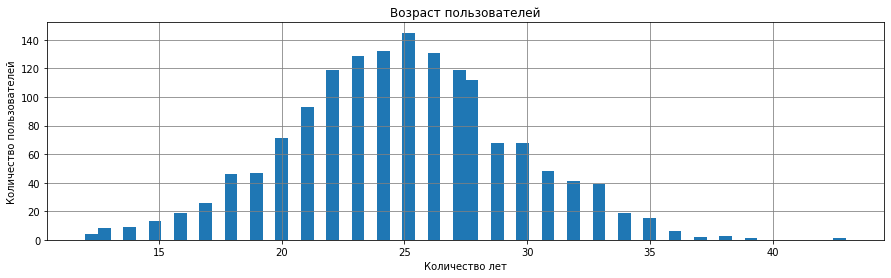

In [ ]:
plt.figure(figsize=(15, 4))
plt.hist(df_user['age'], bins = 60)
plt.title('Возраст пользователей')
plt.xlabel('Количество лет')
plt.ylabel('Количество пользователей')
plt.grid(color='grey', axis='both', alpha=5)
plt.show()

Основной возраст пользователей самокатами от 20 до 35 лет, но есть видимо еденичные случаи использования и в 5 и в 45. Возможно это родители с детьми.

3.4 расстояние, которое пользователь преодолел за одну поездку;

In [ ]:
# найдем лидеров, преодолевших самое большое расстояние за одну поездку в км
top_rides = round(df_rides['distance'].sort_values(ascending=False)) /1000
top_rides.head()

16309    7.211
16484    7.066
15580    6.908
17171    6.761
17242    6.725
Name: distance, dtype: float64

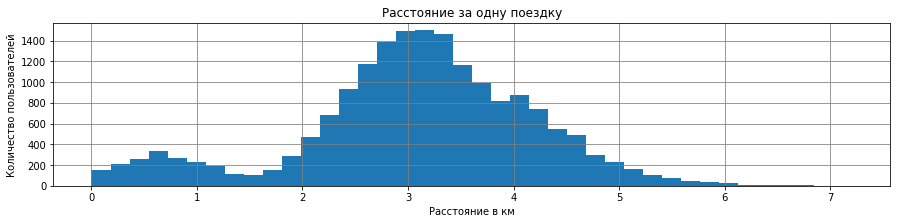

In [ ]:
plt.figure(figsize=(15, 3))
plt.hist(top_rides, bins = 40)
plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние в км')
plt.ylabel('Количество пользователей')
plt.grid(color='grey', axis='both', alpha=5)
plt.show()

Восновном катаются от 2 до 5 км, а кто то смог проехать более 7 км! Видимо самокат может держать заряд так долго! Есть пользователи которые видимо осваивают самокат и катаются от 0 до км.

3.5 продолжительность поездок.

In [ ]:
# найдем лидеров по продолжительности катания в минутах
top_duration = df_rides['duration'].sort_values(ascending=False)
top_duration.head()

4215    40.823963
4709    39.873856
2623    39.526602
1998    38.352763
6453    38.265229
Name: duration, dtype: float64

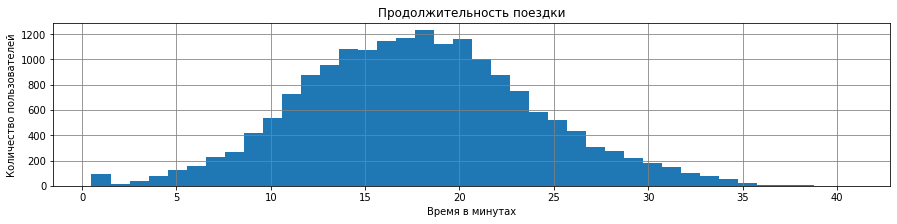

In [ ]:
plt.figure(figsize=(15, 3))
plt.hist(top_duration, bins = 40)
plt.title('Продолжительность поездки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.grid(color='grey', axis='both', alpha=5)
plt.show()

По графику видим, что самокаты берут на прокат в среднем от 5 до 30 минут. Около нуля есть всплеск по пользователям, скорей всего у них что то не получилось с прокатом, либо не понраился самокат и они отменили поездку.

#### Шаг 4. Объединение данных

4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

In [ ]:
# объединим данные из всех таблиц
df_full = df_user.merge(df_sub, on = 'subscription_type')
df_full = df_rides.merge(df_full, on = 'user_id')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [ ]:
# посмотрим еще раз  исходную размерность датасетов
df_user.info()
df_rides.info()
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB
<class 'panda

После объединения размерность таблицы, к которой присоединяем должна совпадать с исходнойВ исходной таблице 18068 записей, проверим что в получившейся объединенной

In [ ]:
# После объединения размерность таблицы, к которой присоединяем должна совпадать с исходной
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Здесь видим, что в объединенной таблице записей столько же как в исходной, занчит все верно!.

4.2 Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
 - c данными о пользователях без подписки;
 - с данными о пользователях с подпиской.

In [ ]:
# поделим датафрейм на два, выделив пользователей с подпиской и без
free_full = df_full.query("`subscription_type` == 'free'")
ultra_full = df_full.query("`subscription_type` == 'ultra'")

4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

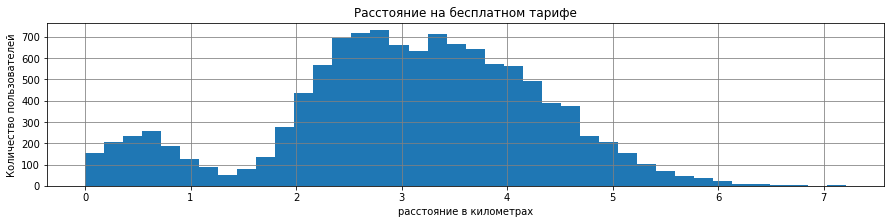

In [ ]:
# расстояние на бесплатном тарифе
free_full_distance = round(free_full['distance'].sort_values(ascending=False)) /1000
plt.figure(figsize=(15, 3))
plt.hist(free_full_distance, bins = 40)
plt.title('Расстояние на бесплатном тарифе')
plt.xlabel('расстояние в километрах')
plt.ylabel('Количество пользователей')
plt.grid(color='grey', axis='both', alpha=5)
plt.show()

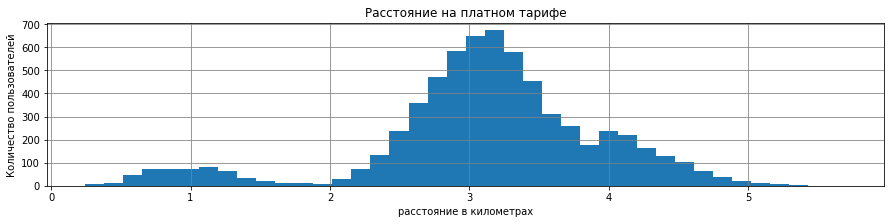

In [ ]:
# расстояние на платном тарифе
ultra_full_distance = round(ultra_full['distance'].sort_values(ascending=False)) /1000
plt.figure(figsize=(15, 3))
plt.hist(ultra_full_distance, bins = 40)
plt.title('Расстояние на платном тарифе')
plt.xlabel('расстояние в километрах')
plt.ylabel('Количество пользователей')
plt.grid(color='grey', axis='both', alpha=5)
plt.show()

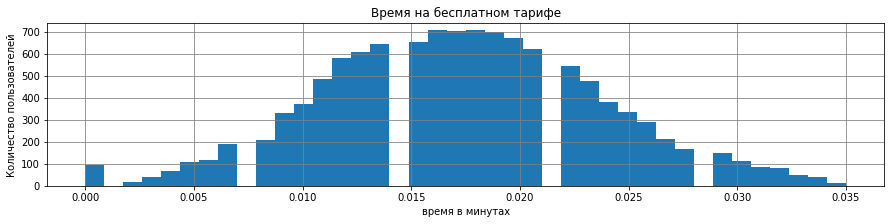

In [ ]:
# время на бесплатном тарифе
free_full_duration = round(free_full['duration'].sort_values(ascending=False)) /1000
plt.figure(figsize=(15, 3))
plt.hist(free_full_duration, bins = 40)
plt.title('Время на бесплатном тарифе')
plt.xlabel('время в минутах')
plt.ylabel('Количество пользователей')
plt.grid(color='grey', axis='both', alpha=5)
plt.show()

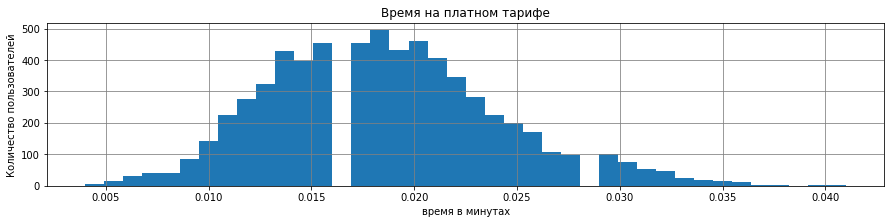

In [ ]:
# время на платном тарифе
ultra_full_duration = round(ultra_full['duration'].sort_values(ascending=False)) /1000
plt.figure(figsize=(15, 3))
plt.hist(ultra_full_duration, bins = 40)
plt.title('Время на платном тарифе')
plt.xlabel('время в минутах')
plt.ylabel('Количество пользователей')
plt.grid(color='grey', axis='both', alpha=5)
plt.show()

 На визуализации видно, что пользователи с подпиской проезжают обычно расстояние от 2 до 4 км, тратя при этом  до 25 минут. Возможно это регулярные планове поездки, для которых и была приобретена подписка.
Пользователи без подписки проезжают и более длительные скорей всего разовые расстояния. По времени разброс от 0 до 35 минут.  Есть пик и около 0 км, новые пользователи у которых видимо что то не получилось с самокатом.
 Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи на платном тарифе, но возможно не так часто.

#### Шаг 5. Подсчёт выручки

5.1 Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [ ]:
# создадим сводную таблицу из объединенного датафрейма df_full с полями: месяц, расстояние, кол-во поездок, время, пользователь, тип подписки
df_total = pd.pivot_table(df_full,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum,
                                      'duration' : sum,
                                      'name' : len,
                                      'subscription_type' : min})
# переименуем поле name в count_sub
df_total.rename(columns = {'name' : 'count_sub'}, inplace = True)
# отсортируем по количеству поездок и выведем получившуюся таблицу
df_total.sort_values(by='count_sub', ascending = False).head(20)

distance    duration  count_sub subscription_type
month user_id                                                   
5     1083      23430.0  124.916782          7              free
4     1424      21528.0  120.269714          7              free
1     1383      20653.0  119.673964          6              free
4     775       19143.0   93.838265          6              free
1     1471      23098.0  140.264426          6              free
9     1246      17671.0  102.899348          6              free
3     1196      17992.0  118.567466          6              free
      617       20008.0  123.062927          6             ultra
12    715       22713.0  127.195642          6              free
5     938       19062.0  107.705211          6              free
4     1329      12700.0   84.984517          5              free
8     1468      20619.0   98.778212          5              free
6     1206      13424.0   87.930618          5              free
4     1365      18190.0   89.577891          5              free
11    1355      16908.0   91.558948          5              free
5     1055      15687.0   90.190639          5              free
4     1389      17230.0   98.013406          5              free
2     700       13446.0   85.829845          5              free
8     716       13516.0   88.251453          5              free
6     957       16389.0  102.839981          5              free

In [ ]:
# самое большое количество поездок у пользователя с user_id 924, посмотрим как он ездил в другие месяцы
df_total.query('user_id == 924')

,,distance,duration,count_sub,subscription_type
month,user_id,,,,
2,924,8452.0,46.468288,3,free
4,924,5642.0,33.290729,2,free
5,924,5278.0,24.395422,1,free
8,924,841.0,16.017500,1,free
9,924,4711.0,18.468914,1,free
10,924,15561.0,79.226594,4,free
11,924,3644.0,17.808953,1,free


Видно, что пользоваетль без подписки очень часто пользуется прокатом самоката. Надо посоветовать ему купить подписку ))) Найдем пользователя с таким же количеством поездок, но с подпиской, например с user_id = 659

In [ ]:
df_total.query('user_id == 659')

,,distance,duration,count_sub,subscription_type
month,user_id,,,,
1,659,8094.0,36.442107,2,ultra
2,659,4063.0,14.405772,1,ultra
4,659,3418.0,12.916471,1,ultra
5,659,2458.0,13.532200,1,ultra
6,659,13972.0,60.893890,4,ultra
8,659,2714.0,27.284156,1,ultra
9,659,2177.0,28.036769,2,ultra
10,659,4237.0,20.105186,1,ultra


Он пользуется прокатом не по одному разу почти каждый месяц!

5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения
25.3
25.3,
25.5
25.5 и
26.0
26.0 должны быть преобразованы к
26
26.

Продолжительность каждой поездки должна быть округлена с помощью метода «потолок» библиотеки numpy — np.ceil():

Помесячная выручка считается по формуле: (стоимость старта поездки
×
×  количество поездок)
+
+ стоимость одной минуты поездки
×
× общая продолжительность всех поездок в минутах)
+
+ стоимость подписки.

In [ ]:
#  округлим duration с помощью метода «потолок» библиотеки numpy — np.ceil()
df_total['duration'] = np.ceil(df_total['duration'])
df_total

distance  duration  count_sub subscription_type
month user_id                                                 
1     1          7028.0      42.0          2             ultra
      3          3062.0      13.0          1             ultra
      5          3915.0      13.0          1             ultra
      7          6478.0      28.0          2             ultra
      12         3577.0      33.0          1             ultra
...                 ...       ...        ...               ...
12    1525       4598.0      34.0          1              free
      1526       3644.0      23.0          1              free
      1528       3999.0      11.0          1              free
      1532       6112.0      41.0          2              free
      1534       2372.0      16.0          1              free

[11331 rows x 4 columns]

In [ ]:
# создадим функцию, которая расчитывает выручку помесячно в зависимости от подписки
def revenue(row):
    # если есть подписка, то цена в месяц 199 (абонем) + 6 р минута
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    # если подписки нет, то цена  8 р минута + 50 р за кадрую поездку
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['count_sub']
    else:
        return 'Not such sub'

In [ ]:
# добавим столбец с помесячной выручкой, которую принёс каждый пользователь
df_total['rev_month'] = df_total.apply(revenue, axis=1)
# отсортируем по столбцу с выручкой
df_total.sort_values(by='rev_month', ascending = False).head(20)

,,distance,duration,count_sub,subscription_type,rev_month
month,user_id,,,,,
1,1471,23098.0,141.0,6,free,1428.0
5,1083,23430.0,125.0,7,free,1350.0
12,715,22713.0,128.0,6,free,1324.0
4,1424,21528.0,121.0,7,free,1318.0
1,1383,20653.0,120.0,6,free,1260.0
3,1196,17992.0,119.0,6,free,1252.0
5,938,19062.0,108.0,6,free,1164.0
12,1149,18449.0,114.0,5,free,1162.0
3,991,18244.0,111.0,5,free,1138.0


Судя по полученным данным самая большая выручка за месяц от пользователей без подписки!

In [ ]:
# посмотрим кто больше принес выручки, для этого сгруппируем по виду подписки
df_total.groupby('subscription_type').sum()

,distance,duration,count_sub,rev_month
subscription_type,,,,
free,35230285.0,204585.0,11568,2215080.0
ultra,20250382.0,122755.0,6500,1638597.0


Получается, что пользователи без подписки проехали больше км, потратили больше времени и приносят больше дохода!

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

H_0: Время (duration) пользователей на подписке ultra = время (duration) пользователей на подписке free

H_1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

alpha = 0.05

In [ ]:
# Возьмем созданные отдельные датафреймы по подпискам  в 4.2 и сравним
ultra = ultra_full['duration']
free = free_full['duration']
results = st.ttest_ind(ultra,
                       free,
                       alternative = 'greater')
alpha = 0.05
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


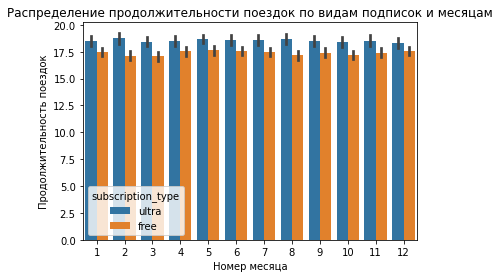

In [ ]:
x = sns.barplot(data=df_full, x = 'month', y="duration", hue = "subscription_type")
x.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
x.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');

Проверили гипотезу, отвергли гипотезу о том, что время поездки пользователей на тарифе ultra равно времени поездки пользователей на тарифе free. По тесту выходит, что время использования самокатом на тарифе ultra больше чем на тарифе free. Первоначальные мои выводы о том, что пользователи на бесплатном тарифе катаются долше не подтвердились.

6.2 Расстояние одной поездки в
3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает
3130 метров? Проверьте гипотезу и сделайте выводы.

H_0: Расстояние (distance) пользователей на подписке за одну поездку ultra = 3130 метров

H_1: Расстояние (distance) пользователей на подписке за одну поездку ultra > 3130 метров

H_1: Расстояние (distance) пользователей на подписке за одну поездку ultra > 3130 метров

In [ ]:

ultra_distance = ultra_full['distance']

int_value = 3130

alpha = 0.05

results = st.ttest_1samp(
    ultra_distance,
    int_value,
    alternative= 'greater') # проверяем больше ли среднее значение , чем 3130

print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195649894697724
Не удалось отвергнуть нулевую гипотезу


Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra за одну поездку не равно 3130 метров.

6.3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

H_0: Выручка (revenue_per_month) пользователей на подписке ultra = выручка (rev_month) пользователей на подписке free

H_1: Выручка (revenue_per_month) пользователей на подписке ultra > выручка (rev_month) пользователей на подписке free

alpha = 0.05

In [ ]:
ultra_per_mnth = df_total.loc[df_total.subscription_type == 'ultra', 'rev_month']
free_per_mnth = df_total.loc[df_total.subscription_type == 'free', 'rev_month']
results = st.ttest_ind(ultra_per_mnth, free_per_mnth, alternative = 'greater')
alpha = 0.05
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

2.8130926188487286e-35
Отвергаем нулевую гипотезу


Здесь по резулату тест видим, что значение pvalue очень мало, поэтому отвергаем нулевую гипотезу и шансов, что выручки от пользователей на подписке и без равны практически нет.

6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Здесь можем использовать гипотезу о равенстве средних для зависимых  выборок.

Сформулируем гипотезы:

H0 : μ1 = μ2
H1 : μ1 != μ2
где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.
Нужно использовать биномиальное распределение, которое описывает указанную ситуацию. Затем подобрать подходящее значение параметра
N для заданного параметра p=0.1 с помощью графиков и метода cdf() , сформулировать вывод и ответ.

Определим значение параметра n, начиная с некоторого числа (например, с 1) и увеличивая его до тех пор, пока значение cdf(N) не станет выше 0.95 (т.е. вероятность не выполнить план будет меньше 5%).

In [ ]:
p = 0.1 # вероятность продления подписки
target_prob = 0.05 # вероятность не выполнить план
n = 1
while binom.cdf(n, 100, p) < 1 - target_prob:
     n += 1
print("Минимальное количество промокодов: ", n)

Минимальное количество промокодов:  15


Построим график

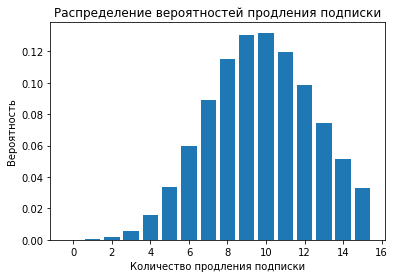

In [ ]:
x = np.arange(0, n+1)
y = binom.pmf(x, 100, p)

plt.bar(x, y)
plt.xlabel('Количество продления подписки')
plt.ylabel('Вероятность')
plt.title('Распределение вероятностей продления подписки')
plt.show()

По графику и расчетам можно сделать следующие выводы:

В результате  выводится минимальное количество промокодов (15), которое нужно предложить для достижения вероятности не выполнить план (5%).
Распределение вероятностей продления подписки имеет форму биномиального распределения. Вероятность наиболее высока для небольшого количества продлений и уменьшается по мере увеличения количества продлений. Это ожидаемый результат, так как с каждым следующим продлением вероятность отказа увеличивается.
График наглядно демонстрирует, как вероятность продления подписки меняется с увеличением количества продлений. Это может помочь принять решение о необходимом количестве промокодов для достижения заданной вероятности.

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать
1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Эта ситуация тоже описывается биномиальным распределением. Но считать каждое отдельное значение достаточно долго. Вы можете воспользоваться нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки.

In [ ]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4
# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma)
# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


Теперь у нас есть оценка вероятности того, что уведомление откроют не более 399,5 тыс. пользователей и это около 15%.

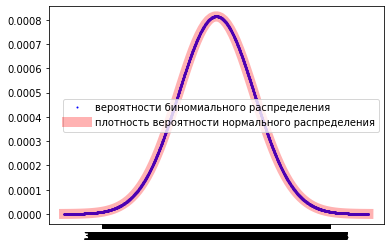

Условие выполняется


In [ ]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
# зададим набор значений биномиальной величины на выбр анном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=1,
	      label='вероятности биномиального распределения')
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 10 и прозрачности 0.3
ax.plot(x, st.norm.pdf(x, mu, sigma), 'r-', lw=10, alpha=0.3, label='плотность вероятности нормального распределения')
 # зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)
# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()
# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

<b>Вывод:</b>







В ходе данного проекта мы загрузили три датафрейма с пользователями, информацией о поездках, информацией о подписках.
Далее была проведена предобработка данных: данные проверены на пропуски, изменен тип данных у столбца date, добавлен столбец month с номером месяца.

В ходе исследовательского анализа выявили, что самое больщое количество пользователей самокатами в горде Пятигорск, за ним идет Екатеринбург, а на последнем месте почему то оказалась Москва. Выяснили так же, что количество пользователей без подписки больше, чем с подпиской примерно на 10%. Вычислили основной возраст для пользователей самокатами от 20 до 35 лет, но встречаются пользователи - дети до 15 и взрослые до 45 лет.  В среднем пользователи берут самокат на время от 5 до 30 минут и проезжают расстояние от 2 до 5 км.

Далее были объединены все три датафрейма в один, а затем поделены на две категории с подпиской и без. В итоге исследования сделали вывод, что пользователи без подписки приносят прокату самокатов больше дохода, чем пользователи с подпиской и проезжают большее расстояние, тратя больше времени на поздки, чем пользователи с подпиской. Хотя проверяя дальше гипотезы это не подтвердилось. Проверяли гипотезу, что время пользователей с подпиской равно времени пользователей без подписки и эту гипотезу не подтвердили. так же отвергли гипотезу о том чторасстояние одной поздки пользователй с подпиской и без равны. Гипотеза о равенстве выручки так же отвергнута.

На 7 шаге  удалось расчитать минимальное количество промокодов, которое нужно предложить пользователям, для достижения вероятности не выполнить план на 5%. Выяснили что вероятность наиболее высока для небольшого количества продлений и уменьшается по мере увеличения количества продлений. Это ожидаемый результат, так как с каждым следующим продлением вероятность отказа увеличивается.

В конце исследования удалось получить оценку вероятности того, что уведомление откроют не более 399,5 тыс. пользователей и это около 15%.
Далее с пмощью аппроксимации построили примерный график распределения.